In [1]:
!pip install ISLP

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 16.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 9.1 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.0/522.0 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 5.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 22.3 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.7/115.7 kB 9.0 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4031 sha256=d224a36f0ba0b834f9b8e9cf8c4b2a8eae54e85903088ee1c327b8c9ca334a97
  Stored in directory: /root/.cache/pip/wheels/25/cc/e0/ef2969164144c899fedb22b338f6703e2b9cf46eeebf254991
Successfully buil

In [2]:
import numpy as np
import statsmodels.api as sm
from ISLP import load_data
from ISLP.models import (ModelSpec as MS, summarize, poly)
from sklearn.model_selection import train_test_split

In [3]:
from functools import partial
from sklearn.model_selection import (cross_validate, KFold, ShuffleSplit)
from sklearn.base import clone
from ISLP.models import sklearn_sm

In [4]:
auto = load_data('Auto')
auto_train, auto_valid = train_test_split(auto, test_size = 0.2, random_state = 86)

In [5]:
X_train = MS(['horsepower']).fit_transform(auto_train)
y_train = auto_train['mpg']
model = sm.OLS(y_train, X_train)
results = model.fit()

In [6]:
X_valid = MS(['horsepower']).fit_transform(auto_valid)
y_valid = auto_valid['mpg']
y_pred = results.predict(X_valid)
np.mean((y_valid - y_pred)**2)

21.719918027774366

In [7]:
def evalMSE(terms, response, train, test):
    mm = MS(terms)
    X_train = mm.fit_transform(train)
    y_train = train[response]
    X_test = mm.transform(test)
    y_test = test[response]
    results = sm.OLS(y_train, X_train).fit()
    y_pred = results.predict(X_test)
    return np.mean((y_test- y_pred)**2)

In [8]:
MSE = np.zeros(5)
for idx, degree in enumerate(range(1, 6)):
    MSE[idx] = evalMSE([poly('horsepower', degree)], 'mpg', auto_train, auto_valid)

MSE

array([21.71991803, 16.90733309, 16.84324749, 16.95747177, 16.38256945])

Wrapper of the above function

In [9]:
hp_model = sklearn_sm(sm.OLS, MS(['horsepower']))
X, y = auto.drop(columns = ['mpg']), auto['mpg'] 
cv_results = cross_validate(hp_model, X, y, cv = auto.shape[0])
cv_err = np.mean(cv_results['test_score'])
cv_err

24.23151351792922

In [10]:
cv_error = np.zeros(5)
H = np.array(auto['horsepower'])
M = sklearn_sm(sm.OLS)
for idx, degree in enumerate(range(1, 6)):
    X = np.power.outer(H, np.arange(degree+1))
    cv_results = cross_validate(M, X, y, cv = auto.shape[0])
    cv_error[idx] = np.mean(cv_results['test_score'])
cv_error

array([24.23151352, 19.24821312, 19.33498406, 19.42443029, 19.03320648])

In [11]:
cv_error = np.zeros(5)
H = np.array(auto['horsepower'])
M = sklearn_sm(sm.OLS)
cv = KFold(n_splits = 10, shuffle = True, random_state = 86)
for idx, degree in enumerate(range(1, 6)):
    X = np.power.outer(H, np.arange(degree+1))
    cv_results = cross_validate(M, X, y, cv = cv)
    cv_error[idx] = np.mean(cv_results['test_score'])
cv_error

array([23.9912775 , 19.11601696, 19.2024127 , 19.25279152, 18.8646999 ])

In [12]:
validation = ShuffleSplit(n_splits = 10, test_size = 0.2, random_state = 86)
results = cross_validate(hp_model, auto.drop(['mpg'], axis = 1), auto['mpg'], cv = validation)
results['test_score'].mean()

24.02006423215311

Applied

In [13]:
default = load_data('Default')
default.head(5)

,default,student,balance,income
0,No,No,729.526495,44361.625074
1,No,Yes,817.180407,12106.134700
2,No,No,1073.549164,31767.138947
3,No,No,529.250605,35704.493935
4,No,No,785.655883,38463.495879


<Axes: title={'center': 'income'}, xlabel='default'>

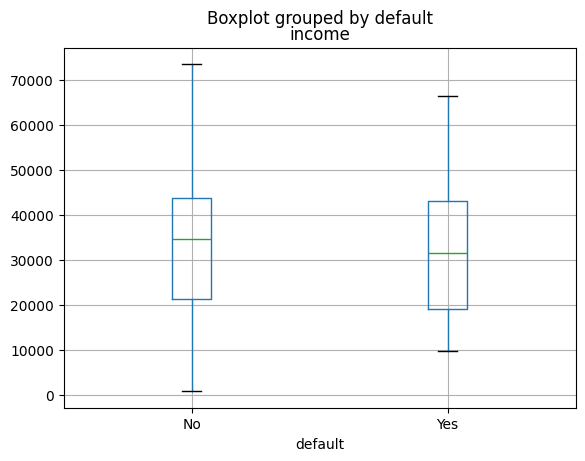

In [14]:
default.boxplot(column = 'income', by = 'default')

array([[<Axes: xlabel='balance', ylabel='balance'>,
        <Axes: xlabel='income', ylabel='balance'>],
       [<Axes: xlabel='balance', ylabel='income'>,
        <Axes: xlabel='income', ylabel='income'>]], dtype=object)

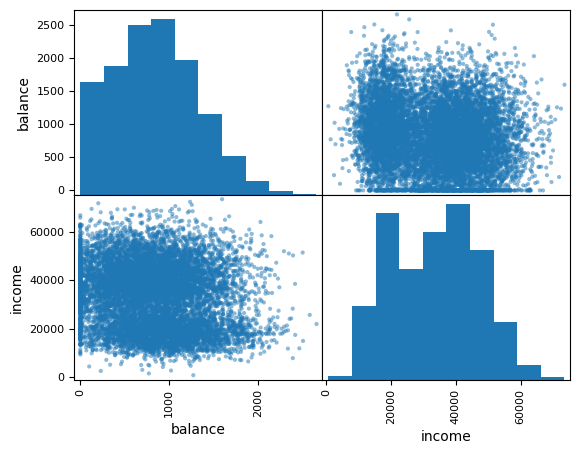

In [15]:
import pandas as pd
pd.plotting.scatter_matrix(default)

In [16]:
from ISLP import confusion_table
X = MS(default.drop(['default', 'student'], axis = 1)).fit_transform(default)
y = default.default == 'Yes'

model = sm.GLM(y, X, family = sm.families.Binomial()).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                default   No. Observations:                10000
Model:                            GLM   Df Residuals:                     9997
Model Family:                Binomial   Df Model:                            2
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -789.48
Date:                Mon, 23 Dec 2024   Deviance:                       1579.0
Time:                        16:07:10   Pearson chi2:                 6.95e+03
No. Iterations:                     9   Pseudo R-squ. (CS):             0.1256
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    -11.5405      0.435    -26.544      0.000     -12.393     -10.688
balance        0.0056      0.000     24.835      0.000       0.005       0.006
income      2.081e-05   4.99e-06      4.174      0.000     1.1e-05    3.06e-05
==============================================================================
"""

Test error: 0.02400000000000002
Precision: 0.8181818181818182
Recall: 0.391304347826087


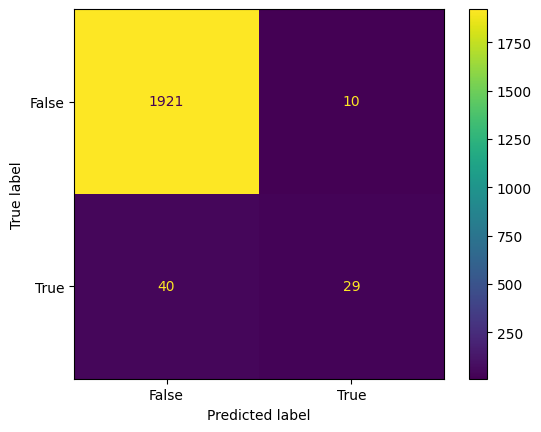

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

logis = LogisticRegression(C = 1e5, solver = 'liblinear')
scaler = StandardScaler(with_mean=True, with_std=True, copy=True)
X_scaled = scaler.fit_transform(default.drop(columns = ['default', 'student']))
y = default['default'] == 'Yes' # Opposite to the above to correct the ConfusionMatrixDisplay 
(X_train, X_test, y_train, y_test) = train_test_split(X_scaled, y, test_size = 0.2, random_state = 86)
logis_model = logis.fit(X_train, y_train)
y_pred = logis_model.predict(X_test)

test_err = 1 - accuracy_score(y_test, y_pred)
print(f'Test error: {test_err}')
print(f'Precision: {precision_score(y_test, y_pred)}')
print(f'Recall: {recall_score(y_test, y_pred)}')

y_pred_cv = cross_val_predict(logis_model, X_test, y_test, cv = 5)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_cv)
plt.show()


Q9

In [18]:
boston = load_data('Boston')

In [22]:
mu_hat = boston['medv'].mean()
SE_mu_hat = boston['medv'].std()/(boston.shape[0])**0.5
means = []
for _ in range(1000):
    means.append(boston['medv'].sample(n = boston.shape[0], replace = True).mean())
boot_std = np.std(means)
print(f'Estimate population mean: {mu_hat}')
print(f'Standard error: {SE_mu_hat}')
print(f'Standard error using bootstrap: {SE_mu_hat}')
print(f'Confidence interval: [{mu_hat - 2*SE_mu_hat} - {mu_hat + 2*SE_mu_hat}]')

mu_med = boston['medv'].median()
medians = []
for _ in range(1000):
    medians.append(boston['medv'].sample(n = boston.shape[0], replace = True).median())
boot_med_std = np.std(medians)
print(f'Standard error of mu_med using bootstrap: {boot_med_std}')

Estimate population mean: 22.532806324110677
Standard error: 0.4088611474975351
Standard error using bootstrap: 0.4088611474975351
Confidence interval: [21.715084029115605 - 23.35052861910575]
Standard error of mu_med using bootstrap: 0.37265342813396973
